In [1]:
# ============================================================
# PROJECT: EFFECT OF WEATHER CONDITIONS ON GROCERY SALES IN ECUADOR
# SECTION 1: LOAD AND INSPECT SALES DATA
# ============================================================

# Importing the required libraries
import pandas as pd
import numpy as np

# ------------------------------------------------------------
# 1. LOAD ECUADOR SALES DATA
# ------------------------------------------------------------
# The dataset contains daily sales information for different stores and product families
# along with additional variables such as promotion status, holidays, and location details.
# File format: CSV
# Columns: date, store_nbr, family, sales, onpromotion, city, state, is_holiday, etc.
# ------------------------------------------------------------
ecuador_sales = pd.read_csv("ecuador_sales.csv", parse_dates=['date'])

# ------------------------------------------------------------
# 2. INITIAL INSPECTION
# ------------------------------------------------------------
# Display dataset structure (column names, data types, non-null counts)
print("=== BASIC INFORMATION ABOUT THE SALES DATA ===")
print(ecuador_sales.info())

# Display first few rows to preview the content
print("\n=== SAMPLE RECORDS ===")
print(ecuador_sales.head())

# ------------------------------------------------------------
# 3. MISSING VALUE CHECK
# ------------------------------------------------------------
# This helps identify any missing data before cleaning or merging with weather data.
print("\n=== MISSING VALUE SUMMARY ===")
print(ecuador_sales.isna().sum())

=== BASIC INFORMATION ABOUT THE SALES DATA ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB
None

=== SAMPLE RECORDS ===
   id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0

=== MISSING VALUE SUMMARY ===
id             0
date           0
store_nbr      0
family         0
sales 

In [2]:
# ============================================================
# SECTION 1B: DATA CLEANING AND FEATURE ENGINEERING
# ============================================================

# ------------------------------------------------------------
# 3. ENSURE CORRECT DATA TYPES
# ------------------------------------------------------------
# Convert relevant columns to categorical data types for efficient analysis.
# This improves memory usage and ensures correct statistical treatment later.
if 'store_nbr' in ecuador_sales.columns:
    ecuador_sales['store_nbr'] = ecuador_sales['store_nbr'].astype('category')

if 'family' in ecuador_sales.columns:
    ecuador_sales['family'] = ecuador_sales['family'].astype('category')


# ------------------------------------------------------------
# 4. REMOVE OR HANDLE INVALID / NEGATIVE SALES VALUES
# ------------------------------------------------------------
# Negative sales values are logically impossible and likely due to entry errors.
# These are replaced with zero to maintain data consistency.
invalid_sales = ecuador_sales[ecuador_sales['sales'] < 0]
if not invalid_sales.empty:
    print("Warning: Found negative sales values — replacing them with 0.")
    ecuador_sales.loc[ecuador_sales['sales'] < 0, 'sales'] = 0


# ------------------------------------------------------------
# 5. SORT DATA BY DATE (TIME-SERIES CONSISTENCY)
# ------------------------------------------------------------
# Sorting ensures that all time-based analyses (e.g., trend or lag variables)
# are performed in chronological order within each store and product family.
ecuador_sales = ecuador_sales.sort_values(['store_nbr', 'family', 'date'])


# ------------------------------------------------------------
# 6. FEATURE ENGINEERING (CALENDAR VARIABLES)
# ------------------------------------------------------------
# Extract temporal features that can help explain sales variation:
# - Day of week (0 = Monday, 6 = Sunday)
# - Month and Year (seasonal trends)
# - Weekend flag (binary: 1 for Saturday/Sunday, 0 otherwise)
ecuador_sales['day_of_week'] = ecuador_sales['date'].dt.dayofweek
ecuador_sales['month'] = ecuador_sales['date'].dt.month
ecuador_sales['year'] = ecuador_sales['date'].dt.year
ecuador_sales['is_weekend'] = ecuador_sales['day_of_week'].isin([5, 6]).astype(int)


# ------------------------------------------------------------
# 7. OVERVIEW AFTER CLEANING AND FEATURE CREATION
# ------------------------------------------------------------
print("\n=== CLEANED SALES DATA SAMPLE ===")
print(ecuador_sales.head())

print("\n=== SUMMARY STATISTICS ===")
print(ecuador_sales.describe())



=== CLEANED SALES DATA SAMPLE ===
        id       date store_nbr      family  sales  onpromotion  day_of_week  \
0        0 2013-01-01         1  AUTOMOTIVE    0.0            0            1   
1782  1782 2013-01-02         1  AUTOMOTIVE    2.0            0            2   
3564  3564 2013-01-03         1  AUTOMOTIVE    3.0            0            3   
5346  5346 2013-01-04         1  AUTOMOTIVE    3.0            0            4   
7128  7128 2013-01-05         1  AUTOMOTIVE    5.0            0            5   

      month  year  is_weekend  
0         1  2013           0  
1782      1  2013           0  
3564      1  2013           0  
5346      1  2013           0  
7128      1  2013           1  

=== SUMMARY STATISTICS ===
                 id                           date         sales  \
count  3.000888e+06                        3000888  3.000888e+06   
mean   1.500444e+06  2015-04-24 08:27:04.703088640  3.577757e+02   
min    0.000000e+00            2013-01-01 00:00:00  0.000000

In [3]:
# ============================================================
# SECTION 2: MERGING SALES DATA WITH STORE INFORMATION
# ============================================================

import pandas as pd

# ------------------------------------------------------------
# 1. LOAD STORE METADATA
# ------------------------------------------------------------
# The stores.csv file contains additional information such as
# city, state, and store type, which will be useful for analysis.
stores = pd.read_csv("stores.csv")

print("\n=== STORES DATA OVERVIEW ===")
print(stores.info())
print(stores.head())


# ------------------------------------------------------------
# 2. MERGE SALES DATA WITH STORE INFORMATION
# ------------------------------------------------------------
# We merge the cleaned sales dataset (ecuador_sales) with store-level
# metadata using 'store_nbr' as the common key.
# A left join is used to ensure that all sales records are retained
# even if some stores have missing metadata.
merged_sales = pd.merge(
    ecuador_sales,   # Sales data
    stores,          # Store metadata
    how='left',      # Retain all sales records
    on='store_nbr'   # Common key
)

# ------------------------------------------------------------
# 3. VERIFY THE MERGED DATA
# ------------------------------------------------------------
# Check the structure and sample of the merged dataset
print("\n=== MERGED SALES + STORE DATA OVERVIEW ===")
print(merged_sales.info())
print(merged_sales.head())



=== STORES DATA OVERVIEW ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
None
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

=== MERGED SALES + STORE DATA OVERVIEW ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30

In [4]:
# ============================================================
# SECTION 3: ADDING HOLIDAY INFORMATION TO SALES DATA
# ============================================================

import pandas as pd

# ------------------------------------------------------------
# 1. LOAD AND CLEAN HOLIDAY DATA
# ------------------------------------------------------------
# The holidays_events.csv file contains information about
# national, regional, and local holidays in Ecuador.
# We remove transferred holidays to avoid double-counting.
holidays_df = pd.read_csv("holidays_events.csv", parse_dates=['date'])
holidays_df = holidays_df[holidays_df['transferred'] == False]


print("\n=== HOLIDAY DATA OVERVIEW ===")
print(holidays_df.info())
print(holidays_df.head())


# ------------------------------------------------------------
# 2. CREATE EFFICIENT LOOKUP SETS FOR HOLIDAY TYPES
# ------------------------------------------------------------

# Dates for national holidays
national_holidays = set(
    holidays_df[holidays_df['locale'] == 'National']['date']
)

# (date, state_name) pairs for regional holidays
regional_holidays = set(
    zip(
        holidays_df[holidays_df['locale'] == 'Regional']['date'],
        holidays_df[holidays_df['locale'] == 'Regional']['locale_name']
    )
)

# (date, city_name) pairs for local holidays
local_holidays = set(
    zip(
        holidays_df[holidays_df['locale'] == 'Local']['date'],
        holidays_df[holidays_df['locale'] == 'Local']['locale_name']
    )
)


# ------------------------------------------------------------
# 3. FLAG HOLIDAYS IN THE SALES DATA
# ------------------------------------------------------------
# Using vectorized lookups for speed and efficiency.

# Check if a date is a national holiday
cond_national = merged_sales['date'].isin(national_holidays)

# Check if (date, state) matches a regional holiday
cond_regional = pd.Series(zip(merged_sales['date'], merged_sales['state'])).isin(regional_holidays)

# Check if (date, city) matches a local holiday
cond_local = pd.Series(zip(merged_sales['date'], merged_sales['city'])).isin(local_holidays)

# Combine all conditions into a single binary column
merged_sales['is_holiday'] = (cond_national | cond_regional | cond_local).astype(int)


# ------------------------------------------------------------
# 4. VALIDATE RESULTS
# ------------------------------------------------------------
print("\n=== SALES DATA WITH HOLIDAY FLAG ===")
print(merged_sales.head())
print(f"\nTotal holiday records identified: {merged_sales['is_holiday'].sum()}")



=== HOLIDAY DATA OVERVIEW ===
<class 'pandas.core.frame.DataFrame'>
Index: 338 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         338 non-null    datetime64[ns]
 1   h_type       338 non-null    object        
 2   locale       338 non-null    object        
 3   locale_name  338 non-null    object        
 4   description  338 non-null    object        
 5   transferred  338 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 16.2+ KB
None
        date   h_type    locale locale_name                    description  \
0 2012-02-03  Holiday     Local       Manta             Fundacion de Manta   
1 2012-01-04  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-12-04  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  

C:\Users\Ini\AppData\Local\Temp\ipykernel_16812\1724479933.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  holidays_df = pd.read_csv("holidays_events.csv", parse_dates=['date'])



=== SALES DATA WITH HOLIDAY FLAG ===
     id       date  store_nbr      family  sales  onpromotion  day_of_week  \
0     0 2013-01-01          1  AUTOMOTIVE    0.0            0            1   
1  1782 2013-01-02          1  AUTOMOTIVE    2.0            0            2   
2  3564 2013-01-03          1  AUTOMOTIVE    3.0            0            3   
3  5346 2013-01-04          1  AUTOMOTIVE    3.0            0            4   
4  7128 2013-01-05          1  AUTOMOTIVE    5.0            0            5   

   month  year  is_weekend   city      state type  cluster  is_holiday  
0      1  2013           0  Quito  Pichincha    D       13           1  
1      1  2013           0  Quito  Pichincha    D       13           0  
2      1  2013           0  Quito  Pichincha    D       13           0  
3      1  2013           0  Quito  Pichincha    D       13           0  
4      1  2013           1  Quito  Pichincha    D       13           1  

Total holiday records identified: 257895


In [5]:
# ============================================================
# SECTION 4: INTEGRATING WEATHER DATA INTO SALES DATA
# ============================================================

import requests
import pandas as pd
import time

# ------------------------------------------------------------
# 1. DEFINE REGIONAL CLUSTERS
# ------------------------------------------------------------
# To avoid fetching weather for each city individually,
# cities are grouped into four regional clusters based on
# geographical proximity and climate similarity.

region_clusters = {
    "Coastal": {
        "coords": (-2.2, -79.9),  # Guayaquil area
        "cities": [
            "Guayaquil", "Salinas", "Daule", "Babahoyo", "Quevedo",
            "Playas", "Libertad", "Esmeraldas", "Manta", "El Carmen",
            "Machala", "Santo Domingo"
        ]
    },
    "Highlands-North": {
        "coords": (0.2, -78.5),  # Quito area
        "cities": [
            "Quito", "Cayambe", "Ibarra", "Latacunga",
            "Riobamba", "Guaranda", "Ambato"
        ]
    },
    "Highlands-South": {
        "coords": (-3.0, -79.0),  # Cuenca area
        "cities": ["Cuenca", "Loja", "Machala"]
    },
    "Amazon": {
        "coords": (-1.5, -77.0),  # Puyo area
        "cities": ["Puyo"]
    }
}


# ------------------------------------------------------------
# 2. FUNCTION TO FETCH WEATHER DATA
# ------------------------------------------------------------
def fetch_weather_for_region(lat, lon, start_date, end_date, region):
    """
    Fetches daily weather data for a specific region
    from the Open-Meteo API archive.
    """
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "daily": (
            "temperature_2m_max,temperature_2m_min,precipitation_sum"
        ),
        "timezone": "America/Guayaquil"
    }

    # Retry logic to handle rate limits or connection errors
    for attempt in range(5):
        r = requests.get(url, params=params)
        if r.status_code == 200:
            data = r.json()
            if "daily" not in data:
                print(f"No daily data available for {region}.")
                return pd.DataFrame()

            # Convert JSON response into DataFrame
            df = pd.DataFrame(data["daily"])
            df["date"] = pd.to_datetime(df["time"]).dt.date
            df = df.drop(columns=["time"])
            df["region"] = region
            return df

        elif r.status_code == 429:
            wait = (attempt + 1) * 5
            print(f"Rate limit reached. Retrying {region} in {wait} seconds...")
            time.sleep(wait)
        else:
            r.raise_for_status()

    print(f"Failed to fetch weather data for {region} after multiple retries.")
    return pd.DataFrame()


# ------------------------------------------------------------
# 3. FETCH WEATHER DATA FOR ALL REGIONS
# ------------------------------------------------------------
start_date = "2013-01-01"
end_date = "2017-08-15"
all_weather = []

for region, info in region_clusters.items():
    print(f"\nFetching weather for region: {region}")
    lat, lon = info["coords"]
    df_weather = fetch_weather_for_region(lat, lon, start_date, end_date, region)
    if not df_weather.empty:
        all_weather.append(df_weather)
    time.sleep(2)  # avoid hitting API rate limits

# Combine all weather data into one DataFrame
df_weather_all = pd.concat(all_weather, ignore_index=True)
df_weather_all = df_weather_all.drop_duplicates(subset=["region", "date"])

print("\nWeather data successfully compiled for all regions.")
print(df_weather_all.head())


# ------------------------------------------------------------
# 4. MAP EACH CITY TO ITS REGION
# ------------------------------------------------------------
# A mapping is created to associate each city in the sales data
# with one of the defined regional clusters.
city_to_region = {
    city: region
    for region, info in region_clusters.items()
    for city in info["cities"]
}

merged_sales["region"] = merged_sales["city"].map(city_to_region)


# ------------------------------------------------------------
# 5. MERGE SALES DATA WITH WEATHER DATA
# ------------------------------------------------------------
merged_sales["date"] = pd.to_datetime(merged_sales["date"]).dt.date
df_weather_all["date"] = pd.to_datetime(df_weather_all["date"]).dt.date

final_merged = pd.merge(
    merged_sales,
    df_weather_all,
    on=["region", "date"],
    how="left"
)


# ------------------------------------------------------------
# 6. FINAL VALIDATION
# ------------------------------------------------------------
print("\n=== FINAL MERGED DATASET ===")
print("Shape:", final_merged.shape)
print(final_merged.head())
print(final_merged.info())


Fetching weather for region: Coastal

Fetching weather for region: Highlands-North

Fetching weather for region: Highlands-South

Fetching weather for region: Amazon

Weather data successfully compiled for all regions.
   temperature_2m_max  temperature_2m_min  precipitation_sum        date  \
0                27.3                22.4               10.2  2013-01-01   
1                26.0                22.8                3.8  2013-01-02   
2                26.7                22.1                9.7  2013-01-03   
3                28.6                21.5                6.0  2013-01-04   
4                27.5                23.1                2.6  2013-01-05   

    region  
0  Coastal  
1  Coastal  
2  Coastal  
3  Coastal  
4  Coastal  

=== FINAL MERGED DATASET ===
Shape: (3000888, 19)
     id        date  store_nbr      family  sales  onpromotion  day_of_week  \
0     0  2013-01-01          1  AUTOMOTIVE    0.0            0            1   
1  1782  2013-01-02          1  AUTO

In [6]:
# ============================================================
# SECTION 5: DATA CLEANING AND COLUMN SELECTION
# ============================================================

# ------------------------------------------------------------
# 1. SELECT RELEVANT VARIABLES FOR ANALYSIS
# ------------------------------------------------------------
# Keep only the variables needed for modeling and analysis.
# This helps reduce memory usage and ensures focus on essential features.

columns_to_keep = [
    "date",
    "store_nbr",
    "family",
    "sales",
    "onpromotion",
    "city",
    "state",
    "temperature_2m_max",
    "temperature_2m_min",
    "precipitation_sum",
    "region",
    "is_holiday"
]

# Create a new DataFrame containing only the selected columns
cleaned_data = final_merged[columns_to_keep].copy()


# ------------------------------------------------------------
# 2. REMOVE DUPLICATES (IF ANY)
# ------------------------------------------------------------
cleaned_data = cleaned_data.drop_duplicates()


# ------------------------------------------------------------
# 3. FINAL OVERVIEW
# ------------------------------------------------------------
print("\n=== CLEANED DATA PREVIEW ===")
print(cleaned_data.head())

print("\n=== CLEANED DATA SUMMARY ===")
print(cleaned_data.info())



=== CLEANED DATA PREVIEW ===
         date  store_nbr      family  sales  onpromotion   city      state  \
0  2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1  2013-01-02          1  AUTOMOTIVE    2.0            0  Quito  Pichincha   
2  2013-01-03          1  AUTOMOTIVE    3.0            0  Quito  Pichincha   
3  2013-01-04          1  AUTOMOTIVE    3.0            0  Quito  Pichincha   
4  2013-01-05          1  AUTOMOTIVE    5.0            0  Quito  Pichincha   

   temperature_2m_max  temperature_2m_min  precipitation_sum           region  \
0                20.4                12.3                3.0  Highlands-North   
1                18.9                12.7                1.5  Highlands-North   
2                18.4                12.7                3.5  Highlands-North   
3                18.1                13.4                5.9  Highlands-North   
4                19.9                12.6                1.5  Highlands-North   

   is_holiday 

In [7]:
# ============================================================
# SECTION 6: SEASON CLASSIFICATION (WET AND DRY)
# ============================================================

# ------------------------------------------------------------
# 1. ENSURE DATE FORMAT AND EXTRACT MONTH
# ------------------------------------------------------------
# Convert 'date' column to datetime to enable time-based feature extraction.
cleaned_data['date'] = pd.to_datetime(cleaned_data['date'], errors='coerce')

# Extract the month number (1–12) for seasonal classification.
cleaned_data['month'] = cleaned_data['date'].dt.month


# ------------------------------------------------------------
# 2. DEFINE SEASON CLASSIFICATION FUNCTION
# ------------------------------------------------------------
# Ecuador has two main seasons based on rainfall patterns:
# - Wet Season: December to May
# - Dry Season: June to November
def assign_season(month):
    """Assign 'Wet' or 'Dry' season based on the month."""
    if month in [12, 1, 2, 3, 4, 5]:
        return "Wet"
    else:
        return "Dry"


# ------------------------------------------------------------
# 3. APPLY FUNCTION TO CREATE A NEW 'season' COLUMN
# ------------------------------------------------------------
cleaned_data['season'] = cleaned_data['month'].apply(assign_season)


# ------------------------------------------------------------
# 4. VALIDATE RESULTS
# ------------------------------------------------------------
print("\n=== SEASON CLASSIFICATION PREVIEW ===")
print(cleaned_data[['date', 'month', 'season']].head())

# Optional: Check distribution of records per season
print("\nSeason distribution:")
print(cleaned_data['season'].value_counts())



=== SEASON CLASSIFICATION PREVIEW ===
        date  month season
0 2013-01-01      1    Wet
1 2013-01-02      1    Wet
2 2013-01-03      1    Wet
3 2013-01-04      1    Wet
4 2013-01-05      1    Wet

Season distribution:
season
Wet    1561032
Dry    1439856
Name: count, dtype: int64


In [8]:
# ============================================================
# STEP 1: FILTER FOR GROCERY-RELATED PRODUCT CATEGORIES
# ============================================================

# Define grocery-related product categories
grocery_categories = [
    'BREAD/BAKERY', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS',
    'GROCERY I', 'GROCERY II', 'MEATS', 'POULTRY',
    'PREPARED FOODS', 'PRODUCE', 'SEAFOOD', 'BEVERAGES'
]

# Subset data to include only these categories
df_grocery = cleaned_data[cleaned_data['family'].isin(grocery_categories)].copy()

# Check size and sample
print("Shape of grocery dataset:", df_grocery.shape)
print("\nSample rows from grocery data:\n", df_grocery.head())


Shape of grocery dataset: (1182168, 14)

Sample rows from grocery data:
            date  store_nbr     family   sales  onpromotion   city      state  \
5052 2013-01-01          1  BEVERAGES     0.0            0  Quito  Pichincha   
5053 2013-01-02          1  BEVERAGES  1091.0            0  Quito  Pichincha   
5054 2013-01-03          1  BEVERAGES   919.0            0  Quito  Pichincha   
5055 2013-01-04          1  BEVERAGES   953.0            0  Quito  Pichincha   
5056 2013-01-05          1  BEVERAGES  1160.0            0  Quito  Pichincha   

      temperature_2m_max  temperature_2m_min  precipitation_sum  \
5052                20.4                12.3                3.0   
5053                18.9                12.7                1.5   
5054                18.4                12.7                3.5   
5055                18.1                13.4                5.9   
5056                19.9                12.6                1.5   

               region  is_holiday  month se

In [9]:
# ============================================================
# STEP 2: SAVE CLEANED GROCERY DATASET
# ============================================================

# Save the filtered grocery dataset to CSV for further analysis or modeling
output_path = "ecuador_weather_data.csv"
df_grocery.to_csv(output_path, index=False)

print(f"Cleaned grocery dataset successfully saved to: {output_path}")


Cleaned grocery dataset successfully saved to: ecuador_weather_data.csv


Dataset Shape: (1182168, 14)

Columns: ['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state', 'temperature_2m_max', 'temperature_2m_min', 'precipitation_sum', 'region', 'is_holiday', 'month', 'season']

Data Types:
 date                  datetime64[ns]
store_nbr                      int64
family                        object
sales                        float64
onpromotion                    int64
city                          object
state                         object
temperature_2m_max           float64
temperature_2m_min           float64
precipitation_sum            float64
region                        object
is_holiday                     int64
month                          int64
season                        object
dtype: object

Missing Values:
 date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
temperature_2m_max    0
temperature_2m_min    0


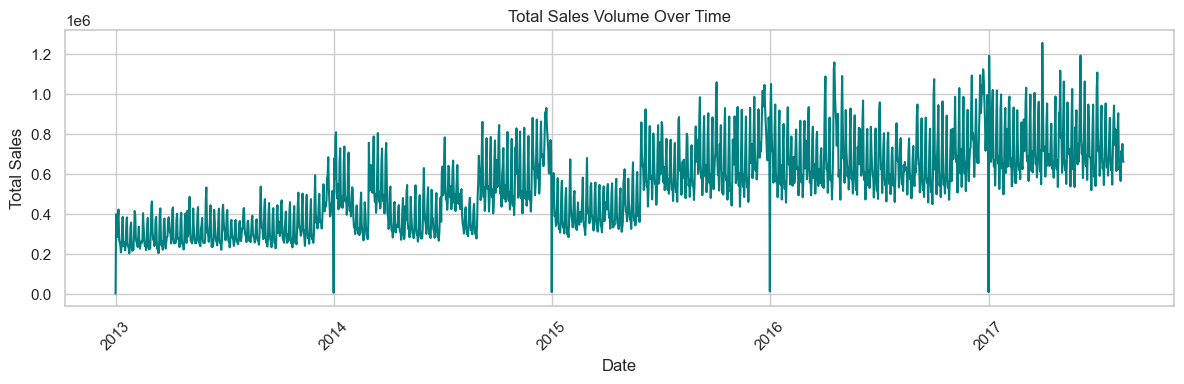

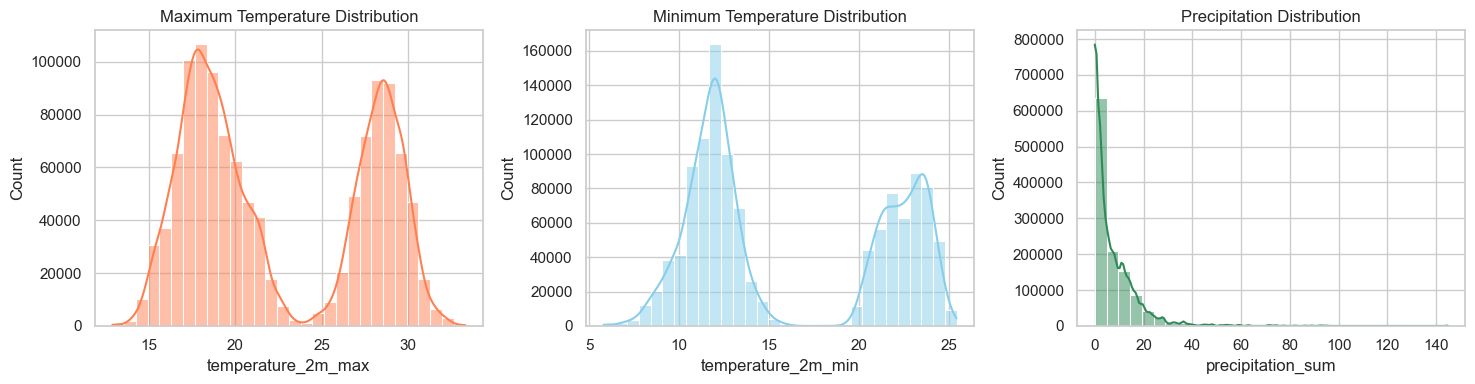


Average Sales (Holiday vs Non-Holiday):
 is_holiday
0    766.596803
1    894.658457
Name: sales, dtype: float64


C:\Users\Ini\AppData\Local\Temp\ipykernel_16812\3204693319.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=holiday_sales.index.astype(str), y=holiday_sales.values, palette='viridis')


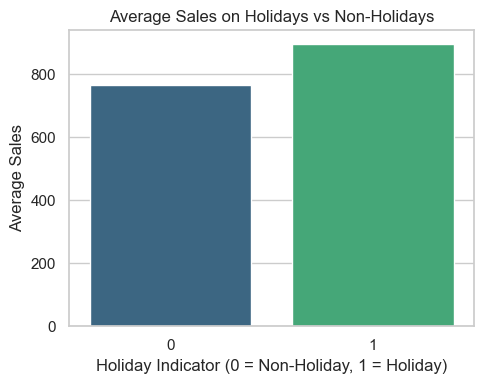

In [10]:
# ============================================================
# VISUALIZATIONS
# ============================================================

# ------------------------------------------------------------
# 1. IMPORT LIBRARIES AND INITIAL SETUP
# ------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set consistent visualization style
sns.set(style="whitegrid")

# ------------------------------------------------------------
# 2. LOAD AND BASIC DATA CHECKS
# ------------------------------------------------------------
# Assuming the dataset has already been loaded
# Rename cleaned_data to df
df = pd.read_csv("ecuador_weather_data.csv")

# Ensure 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Display structure, columns, and data types
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

# Display sample records
print("\nSample Records:\n", df.head())

# Summary statistics (numeric + categorical)
print("\nSummary Statistics:\n", df.describe(include='all'))


# ------------------------------------------------------------
# 3. TIME SERIES EXPLORATION
# ------------------------------------------------------------
# Daily total sales trend
daily_sales = df.groupby('date', as_index=False)['sales'].sum()

plt.figure(figsize=(12, 4))
plt.plot(daily_sales['date'], daily_sales['sales'], color='teal')
plt.title("Total Sales Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# ------------------------------------------------------------
# 4. WEATHER DISTRIBUTIONS
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.histplot(df['temperature_2m_max'], bins=30, ax=axes[0], kde=True, color='coral')
axes[0].set_title('Maximum Temperature Distribution')

sns.histplot(df['temperature_2m_min'], bins=30, ax=axes[1], kde=True, color='skyblue')
axes[1].set_title('Minimum Temperature Distribution')

sns.histplot(df['precipitation_sum'], bins=30, ax=axes[2], kde=True, color='seagreen')
axes[2].set_title('Precipitation Distribution')

plt.tight_layout()
plt.show()


# ------------------------------------------------------------
# 5. HOLIDAY VS NON-HOLIDAY SALES
# ------------------------------------------------------------
holiday_sales = df.groupby('is_holiday')['sales'].mean()
print("\nAverage Sales (Holiday vs Non-Holiday):\n", holiday_sales)

plt.figure(figsize=(5, 4))
sns.barplot(x=holiday_sales.index.astype(str), y=holiday_sales.values, palette='viridis')
plt.title("Average Sales on Holidays vs Non-Holidays")
plt.xlabel("Holiday Indicator (0 = Non-Holiday, 1 = Holiday)")
plt.ylabel("Average Sales")
plt.tight_layout()
plt.show()


In [11]:
# ============================================================
# STEP 2: SAVE CLEANED GROCERY DATASET
# ============================================================

# Save the filtered grocery dataset to CSV for further analysis or modeling
output_path = "ecuador_weather_data.csv"
df_grocery.to_csv(output_path, index=False)

print(f"Cleaned grocery dataset successfully saved to: {output_path}")


Cleaned grocery dataset successfully saved to: ecuador_weather_data.csv


In [12]:
# ==============================================
# WEATHER EFFECTS ON SALES
# This analysis examines how weather variables (temperature and rainfall)
# affect daily grocery sales, controlling for promotions and holidays.
# One-hot encoding is used for categorical weather variables.
# Baseline categories: Normal Temperature, No Rain
# ==============================================

# 1. IMPORT LIBRARIES
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 2. LOAD DATA
# Load sales and weather data
df = pd.read_csv("ecuador_weather_data.csv")

# 3. FEATURE ENGINEERING

# --- Compute average daily temperature ---
df['temperature_2m_avg'] = (df['temperature_2m_max'] + df['temperature_2m_min']) / 2

# --- Categorize temperature into Low / Normal / High based on ±8°C from mean ---
avg_temp = df['temperature_2m_avg'].mean()
df['temp_variation'] = pd.cut(
    df['temperature_2m_avg'],
    bins=[-np.inf, avg_temp - 8, avg_temp + 8, np.inf],
    labels=['Low Temp', 'Normal Temp', 'High Temp']
)

# --- Categorize rainfall intensity ---
# No Rain = 0 mm
# Very Light Rain = <1.0mm
# Light Rain = 1.0 –10.0 mm
# Moderate Rain = 10 - 30mm
# Heavy Rain = >=30 mm
def categorize_precipitation(precip):
    if precip == 0:
        return 'No Rain'
    elif precip < 1.1:
        return 'Very Light Rain'
    elif precip < 10.1:
        return 'Light Rain'
    elif precip < 30.1:
        return 'Moderate Rain'
    else:
        return 'Heavy Rain'

df['rain_intensity'] = df['precipitation_sum'].apply(categorize_precipitation)

# 4. ENCODE CATEGORICAL VARIABLES (ONE-HOT ENCODING)

# --- Temperature dummies ---
# Set "Normal Temp" as baseline (dropped from dummies)
temp_dummies = pd.get_dummies(df['temp_variation'], prefix='temp', drop_first=False)
if 'temp_Normal Temp' in temp_dummies.columns:
    temp_dummies = temp_dummies.drop(columns=['temp_Normal Temp'])
df = pd.concat([df, temp_dummies], axis=1)

# --- Rain intensity dummies ---
# Set "No Rain" as baseline (dropped from dummies)
rain_dummies = pd.get_dummies(df['rain_intensity'], prefix='rain', drop_first=False)
if 'rain_No Rain' in rain_dummies.columns:
    rain_dummies = rain_dummies.drop(columns=['rain_No Rain'])
df = pd.concat([df, rain_dummies], axis=1)

# Drop original categorical columns
df = df.drop(columns=['temp_variation', 'rain_intensity'], errors='ignore')

# 5. DEFINE TARGET AND CONTROL VARIABLES

# Target variable
y = df['sales']

# Ensure holiday indicator is numeric
df['is_holiday'] = df['is_holiday'].astype(int)

# Control variables for regression
control_vars = ['onpromotion', 'is_holiday']

# 6. REGRESSION HELPER FUNCTION
def run_regression(y, X, label):
    """
    Runs an OLS regression and prints the summary table for coefficients.
    """
    X = sm.add_constant(X)  # Add intercept
    model = sm.OLS(y.astype(float), X.astype(float)).fit()
    print(f"\n--- {label} ---")
    print(model.summary().tables[1])  # Show coefficients table
    return model

# 7. RUN REGRESSION MODELS

# --- 7a. Continuous weather variables ---
X_cont = df[['temperature_2m_avg', 'precipitation_sum']]
model_cont = run_regression(y, X_cont, "Continuous Weather Variables (No Controls)")

X_cont_ctrl = df[['temperature_2m_avg', 'precipitation_sum'] + control_vars]
model_cont_ctrl = run_regression(y, X_cont_ctrl, "Continuous Weather Variables (Controlled)")

# --- 7b. Temperature categories (Low / High, baseline = Normal) ---
temp_vars_dummies = [col for col in df.columns if col.startswith('temp_')]
X_temp = df[temp_vars_dummies]
model_temp = run_regression(y, X_temp, "Temperature Categories (No Controls)")

X_temp_ctrl = df[temp_vars_dummies + control_vars]
model_temp_ctrl = run_regression(y, X_temp_ctrl, "Temperature Categories (Controlled)")

# --- 7c. Rainfall intensity categories (Light / Moderate / Heavy, baseline = No Rain) ---
rain_vars_dummies = [col for col in df.columns if col.startswith('rain_')]
X_rain = df[rain_vars_dummies]
model_rain = run_regression(y, X_rain, "Rainfall Intensity (No Rain as Baseline)")

X_rain_ctrl = df[rain_vars_dummies + control_vars]
model_rain_ctrl = run_regression(y, X_rain_ctrl, "Rainfall Intensity (No Rain as Baseline + Controls)")

# 8. CREATE SUMMARY TABLE OF COEFFICIENTS
summary_table = pd.DataFrame({
    "Continuous": model_cont.params,
    "Continuous + Controls": model_cont_ctrl.params,
    "Temp Categories": model_temp.params,
    "Temp + Controls": model_temp_ctrl.params,
    "Rain Categories": model_rain.params,
    "Rain + Controls": model_rain_ctrl.params
}).round(4)

# Print final summary
print("\n============================================================")
print("FINAL SUMMARY COMPARISON (CONTROLLED FOR onpromotion + is_holiday)")
print("BASELINE: Normal Temperature + No Rain")
print("============================================================")
print(summary_table)


ImportError: DLL load failed while importing _fblas: The specified module could not be found.

In [ ]:
# ==============================================
# RANDOM FOREST PERFORMANCE & WEATHER IMPORTANCE BY PRODUCT FAMILY
# Two analyses:
# 1. Controlled for promotion and holiday effects
# 2. Without controlling for promotion and holiday
# ==============================================

# 1. IMPORT LIBRARIES
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# 2. LOAD DATA
df = pd.read_csv("ecuador_weather_data.csv")

# --- Compute average daily temperature ---
df['temperature_2m_avg'] = (df['temperature_2m_max'] + df['temperature_2m_min']) / 2

# ============================
# ANALYSIS 1: CONTROLLED FOR PROMOTION + HOLIDAY
# ============================
# Drop rows with missing values in critical columns
df_ctrl = df.dropna(subset=['sales', 'family', 'temperature_2m_avg', 'precipitation_sum', 'onpromotion', 'is_holiday'])

# Storage for Random Forest results
results_ctrl = []

# Loop through each product family
for family in df_ctrl['family'].unique():
    fam_data = df_ctrl[df_ctrl['family'] == family]

    # --- Step 1: Remove effects of promotion and holiday ---
    control_features = ['onpromotion', 'is_holiday']
    X_ctrl_features = sm.add_constant(fam_data[control_features])
    y_sales = fam_data['sales']

    model_ctrl = sm.OLS(y_sales, X_ctrl_features).fit()
    sales_residuals = model_ctrl.resid  # residual sales after controlling for promotion + holiday

    # --- Step 2: Train Random Forest on residuals using weather features ---
    weather_features = ['temperature_2m_avg', 'precipitation_sum']
    X_weather = fam_data[weather_features]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_weather, sales_residuals, test_size=0.2, random_state=42
    )

    # Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)

    # Performance metrics
    rf_r2 = r2_score(y_test, rf_pred)
    rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

    # Store results
    results_ctrl.append({
        'family': family,
        'rf_r2': rf_r2,
        'rf_rmse': rf_rmse
    })

# Create DataFrame of results sorted by R2
results_ctrl_df = pd.DataFrame(results_ctrl).sort_values(by='rf_r2', ascending=False)

print("\n=== RANDOM FOREST PERFORMANCE BY FAMILY (CONTROLLED FOR PROMOTION + HOLIDAY) ===")
print(results_ctrl_df)

# ============================
# ANALYSIS 2: WITHOUT CONTROL FOR PROMOTION + HOLIDAY
# ============================
# Drop rows with missing values in critical columns
df_no_ctrl = df.dropna(subset=['sales', 'family', 'temperature_2m_avg', 'precipitation_sum'])

# Storage for Random Forest results
results_no_ctrl = []

# Loop through each product family
for family in df_no_ctrl['family'].unique():
    fam_data = df_no_ctrl[df_no_ctrl['family'] == family]

    # Features: only weather variables
    weather_features = ['temperature_2m_avg', 'precipitation_sum']
    X_weather = fam_data[weather_features]
    y_sales = fam_data['sales']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_weather, y_sales, test_size=0.2, random_state=42
    )

    # Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)

    # Performance metrics
    rf_r2 = r2_score(y_test, rf_pred)
    rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

    # Store results
    results_no_ctrl.append({
        'family': family,
        'rf_r2': rf_r2,
        'rf_rmse': rf_rmse
    })

# Create DataFrame of results sorted by R2
results_no_ctrl_df = pd.DataFrame(results_no_ctrl).sort_values(by='rf_r2', ascending=False)

print("\n=== RANDOM FOREST PERFORMANCE BY FAMILY (WITHOUT CONTROL FOR PROMOTION + HOLIDAY) ===")
print(results_no_ctrl_df.head(15))
